In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 參考網站
[Kaggle post written by Yassine](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

In [41]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")
print('train shape: ', train.shape, ', test shape: ', test.shape)

train shape:  (891, 12) , test shape:  (418, 11)


## Outlier detection

In [42]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

D:\Anaconda3\envs\myenv\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [43]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [48]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
train_len = len(train)

## joining train and test set

In [45]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [46]:
# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [50]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 12 columns):
PassengerId    871 non-null int64
Survived       871 non-null int64
Pclass         871 non-null int64
Name           871 non-null object
Sex            871 non-null object
Age            703 non-null float64
SibSp          871 non-null int64
Parch          871 non-null int64
Ticket         871 non-null object
Fare           871 non-null float64
Cabin          201 non-null object
Embarked       869 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 81.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            168
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          670
Embarked         2
dtype: int64

In [51]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,871.000000,871.000000,871.000000,703.000000,871.000000,871.000000,871.000000
mean,447.381171,0.384615,2.300804,29.795405,0.455798,0.362801,31.327233
std,255.836737,0.486784,0.836790,14.539995,0.873655,0.793186,48.228948
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,228.500000,0.000000,2.000000,20.750000,0.000000,0.000000,7.895800
50%,450.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,1.000000,3.000000,38.500000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis

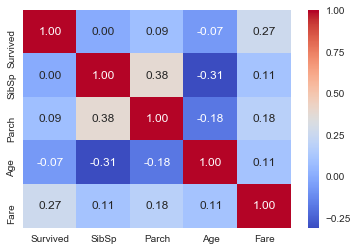

In [52]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### Numerical values - SibSP

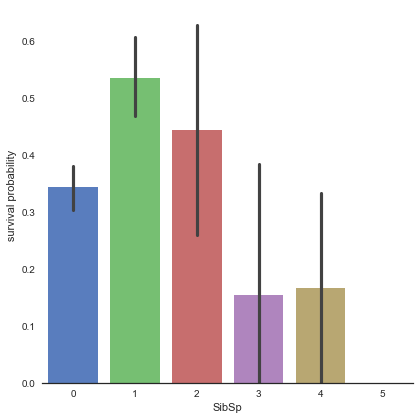

In [53]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Numerical values - Parch

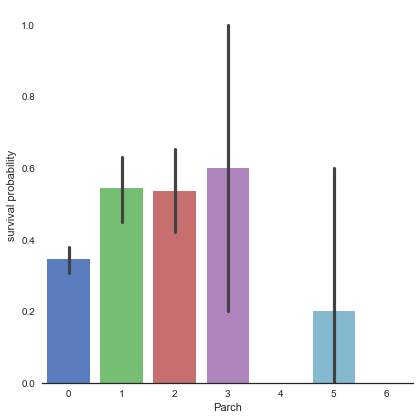

In [54]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

### Numerical values - Age

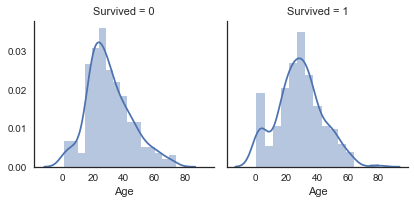

In [55]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

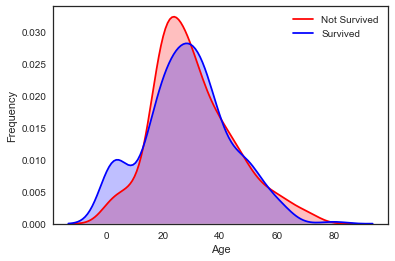

In [56]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

### Numerical values - Fare

In [57]:
dataset["Fare"].isnull().sum()

1

In [58]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

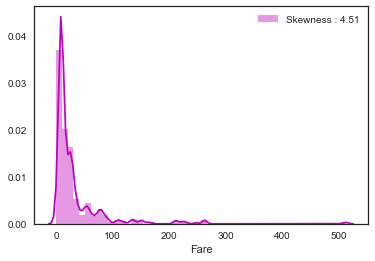

In [59]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [60]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

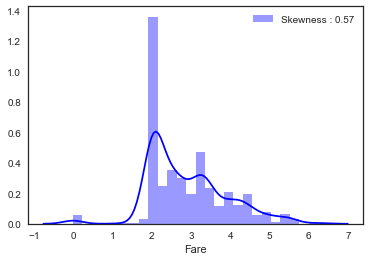

In [61]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

### Categorical values - Sex

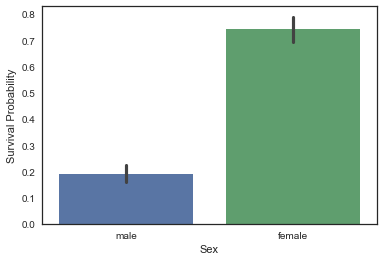

In [70]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [79]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.744262
male,0.190813


In [80]:
train[["Sex","Survived"]].groupby('Sex').std()

,Survived
Sex,
female,0.436992
male,0.393289


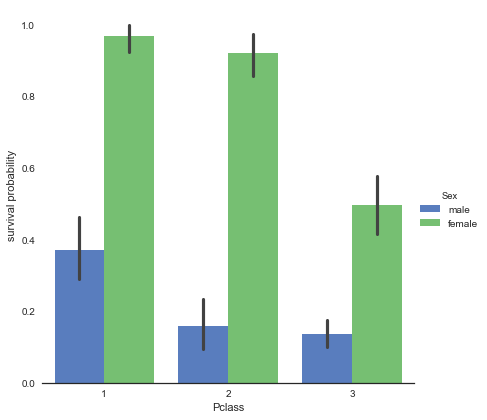

In [85]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [83]:
train[["Pclass", "Sex","Survived"]].groupby(["Pclass", "Sex"]).mean()

Survived
Pclass Sex             
1      female  0.967391
       male    0.371901
2      female  0.921053
       male    0.158879
3      female  0.496350
       male    0.136095

### Categorical values - Embarked

In [86]:
dataset["Embarked"].isnull().sum()

2

In [87]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

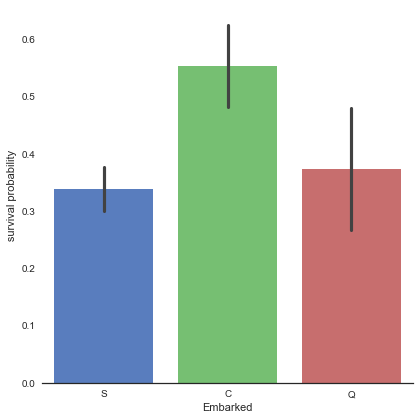

In [91]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")